### Importing necessary libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import re
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [3]:
df_train = pd.read_csv('./NLP3/train.csv')
df_test = pd.read_csv('./NLP3/test.csv')
df_val = df_train.sample(frac = 0.1)

In [4]:
df_train.head()

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


### Preprocess Text

In [5]:
# Function to clean the text data
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Replace '\\' with a space
    text = re.sub(r'\\', ' ', text)
    # Replace '\\\\' with <space>
    text = text.replace('\\\\', ' ')
    # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    return text

In [6]:
# Clean the text for both train and test datasets
df_train['cleaned_text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['cleaned_text'] = df_test['text'].apply(lambda x: clean_text(x))
df_val['cleaned_text'] = df_val['text'].apply(lambda x: clean_text(x))

df_train.head()

,index,text,label,cleaned_text
0,0,Zimbabwe annual inflation drops to 209 percent...,0,zimbabwe annual inflation drops to percent...
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0,more than dead in haiti a m...
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0,seven die in japan suicide pact japan...
3,3,Security No. 1 for Afghan head President Hamid...,0,security no for afghan head president hamid...
4,4,Palestinians say they hope Bush accepts dealin...,0,palestinians say they hope bush accepts dealin...


In [7]:
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\Rohit\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Rohit\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
train_tokenized = tokenizer(df_train['cleaned_text'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors="pt")
val_tokenized = tokenizer(df_val['cleaned_text'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors="pt")
test_tokenized = tokenizer(df_test['cleaned_text'].tolist(), padding='max_length', truncation=True, max_length=512, return_tensors="pt")

### Prepare the DataLoaders

In [9]:
train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'],torch.tensor(df_train['label'].tolist())) 
val_dataset = TensorDataset(val_tokenized['input_ids'], val_tokenized['attention_mask'],torch.tensor(df_val['label'].tolist()))
test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'],torch.tensor(df_test['label'].tolist()))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### Initialize the RoBERTa model 

In [10]:
# Load model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)
optimizer = AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Finetuning RoBERTa

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 4  
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  
    train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert logits to predictions and accumulate
        predictions = torch.argmax(logits, dim=-1)
        train_predictions.extend(predictions.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())

    # Compute training accuracy and loss
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_loader)} | Train Accuracy: {train_accuracy}")

    # Validation loop
    model.eval()
    val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad(): 
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            val_predictions.extend(predictions.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Compute validation accuracy and loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {avg_val_loss} | Val Accuracy: {val_accuracy}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model_save_directory = "/content/drive/MyDrive/NLP_Assignment3/best_model_RoBERTa"
        model.save_pretrained(model_save_directory)
        # tokenizer.save_pretrained(model_save_directory)
        print(f"Saving model at epoch {epoch + 1} with validation loss: {best_val_loss}")




Epoch 1/4 | Train Loss: 0.5940594626665116 | Train Accuracy: 0.789
Epoch 1/4 | Val Loss: 0.331002723139066 | Val Accuracy: 0.895
Saving model at epoch 1 with validation loss: 0.331002723139066
Epoch 2/4 | Train Loss: 0.30666922077536585 | Train Accuracy: 0.904
Epoch 2/4 | Val Loss: 0.29991159215569496 | Val Accuracy: 0.915
Saving model at epoch 2 with validation loss: 0.29991159215569496
Epoch 3/4 | Train Loss: 0.25412551787495613 | Train Accuracy: 0.9245
Epoch 3/4 | Val Loss: 0.23141103553084227 | Val Accuracy: 0.955
Saving model at epoch 3 with validation loss: 0.23141103553084227
Epoch 4/4 | Train Loss: 0.16576270087063313 | Train Accuracy: 0.9555
Epoch 4/4 | Val Loss: 0.13530861177983192 | Val Accuracy: 0.955
Saving model at epoch 4 with validation loss: 0.13530861177983192


### Load and evaluate the saved model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_directory = "./models/best_model_RoBERTa"  
model = RobertaForSequenceClassification.from_pretrained(model_directory)
model.to(device)

model.eval()

test_predictions = []
test_true_labels = []

with torch.no_grad(): 
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=-1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())


In [14]:
accuracy = accuracy_score(test_true_labels, test_predictions)
macro_f1 = f1_score(test_true_labels, test_predictions, average='macro')
clf_report = classification_report(test_true_labels, test_predictions)

print(f"Test Accuracy: {accuracy}")
print(f"Test Macro F1-Score: {macro_f1}")
print(clf_report)

Test Accuracy: 0.872
Test Macro F1-Score: 0.871080617114552
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       125
           1       0.94      0.95      0.95       125
           2       0.85      0.77      0.81       125
           3       0.81      0.94      0.87       125

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



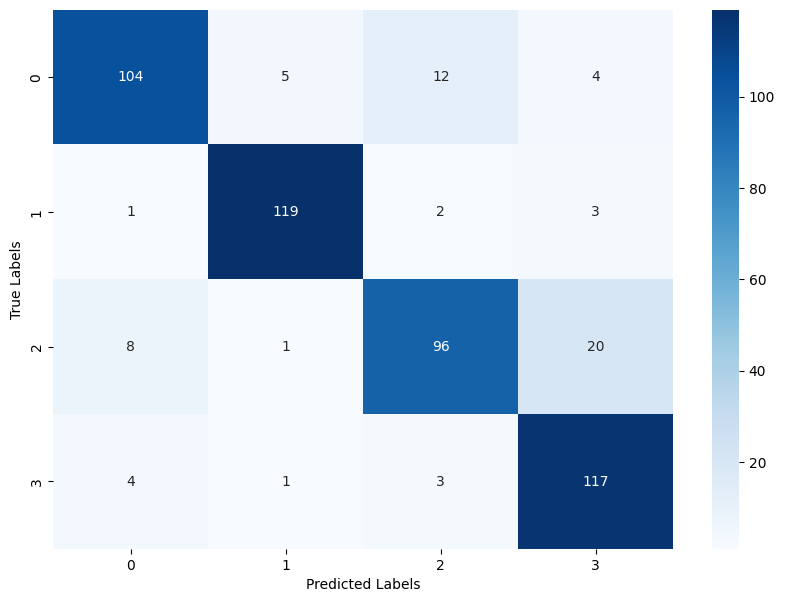

In [15]:
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
# Save predictions in CSV
test_data_with_preds = df_test.copy()
test_data_with_preds = test_data_with_preds.drop(['cleaned_text'], axis=1)
test_data_with_preds['preds'] = test_predictions  # Add a column for predictions
test_data_with_preds.to_csv('bert_test.csv', index=False)